In [79]:
import os
import sys
sys.path.append('../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from libs.utils import filter_glucose_by_range, filter_noisy_data

In [80]:
data_root = "/mnt/data2/mtseng/dataset/SeNSE/TCH_processed/beat"
subject_id = 'c2s04'

In [81]:
df = pd.read_pickle(os.path.join(data_root, f"{subject_id}.pkl"))
print(df.head())
print(df.shape)

                                                Time  \
0  [2022-10-30T23:22:06.674000000, 2022-10-30T23:...   
1  [2022-10-30T23:22:07.422000000, 2022-10-30T23:...   
2  [2022-10-30T23:22:08.154000000, 2022-10-30T23:...   
3  [2022-10-30T23:22:08.910000000, 2022-10-30T23:...   
4  [2022-10-30T23:22:09.690000000, 2022-10-30T23:...   

                                         EcgWaveform  \
0  [2175, 2175, 2173, 2172, 2170, 2169, 2168, 216...   
1  [2090, 2089, 2089, 2088, 2088, 2088, 2088, 208...   
2  [2085, 2084, 2084, 2084, 2083, 2083, 2082, 208...   
3  [2064, 2064, 2064, 2064, 2064, 2064, 2064, 206...   
4  [2047, 2047, 2046, 2045, 2045, 2045, 2046, 204...   

                                                  HR  glucose  CGM_idx  \
0  [65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 6...    171.0  20383.0   
1  [65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 6...    171.0  20383.0   
2  [57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 5...    171.0  20383.0   
3  [57, 57, 57, 57, 57, 57, 57

### Filter the signal

#### Filter out the part that are not in the desired range of glucose value

* Hypoglycemic range: 40 ~ 70 (mg/dL)
* Normal range: 70 ~ 180 (mg/dL)

In [82]:
# only select those in proper range of glucose (40-180)
filtered_df = filter_glucose_by_range(df)

Glucose Level Filtering (remove beats with glucose value outside 40-180 mg/dl ):
 - Original count:  1542725
 - Filtered count:  1327402
 - Availability ratio: 0.860


#### Filter out the noisy data according to the HRConfidence and ECGNoise

For a clean signal, it must satisfies:
* HRConfidence >= 100
* ECGNoise < 0.001

In [83]:
clean_df = filter_noisy_data(filtered_df)

Filter out noisy data (HRConfidence < 100 or ECGNoise >= 0.001):
 - Original:  1327402
 - Filtered:  1244311
 - Availability Ratio: 0.937


### Data Statistics

We define $G$ and $E$ as the set of glucose and ECG respectively.
1. Average glucose in $hg$ (hypoglycemia)
$$
    \text{Average glucose in } hg = \bar G_{hg} = \frac{1}{|G_{hg}|}\sum_{g_i \in G_{hg}} g_i \text{, where } G_{hg} = \{g\in G | g < 70\}
$$
2. Average glucose in $eg$ (euglycemia)
$$
    \text{Average glucose in } eg = \bar G_{eg} = \frac{1}{|G_{eg}|}\sum_{g_i \in G_{eg}} g_i \text{, where } G_{eg} = \{g\in G | 70 \leq g \leq 180 \}
$$
3. Percentage of $hg$ CGM in CGM
$$
    \text{Percentage of } hg = \frac{\# hg}{\# hg + \# eg} = \frac{|G_{hg}|}{|G_{hg}|+|G_{eg}|}
$$
4. Percentage of nocturnal $hg$ CGM
$$
    \text{Percentage of nocturnal } hg = \frac{\# hg \text{ during nocturnal}}{\# hg} = \frac{|G_{hg_n}|}{|G_{hg}|}\text{, where } G_{hg_n} = \{g\in G_{hg} | 0\leq ts(g).hr <7 \} 
$$
5. Average diurnal HR (heart rate)
$$
    \text{Average diurnal HR} = \bar{HR_d} = \frac{1}{|G_{d}|}\sum_{g_i \in G_{d}} HR(g_i) \text{, where } G_{d} = \{g\in G | 7\leq ts(g).hr <24 \} 
$$
6. Average nocturnal heart rate  
$$
    \text{Average nocturnal HR} = \bar{HR_n} = \frac{1}{|G_{n}|}\sum_{g_i \in G_{n}} HR(g_i) \text{, where } G_{n} = \{g\in G | 0\leq ts(g).hr <7 \} 
$$
7. Percentage of clean $eg$ ECG beat in $eg$ ECG beats
$$
    \text{\% clean } eg \text{ ECG beats} = \frac{\# \text{clean } eg \text{ ECG}}{\# eg\text{ ECG}} = \frac{|E^{c}_{eg}|}{|E_{eg}|}\text{, where } E^{c}_{eg} = \{e\in E_{eg} | (HRC(e) \geq 100) \text{ and } (Noise(e)<0.001) \} 
$$
8. Percentage of clean $hg$ ECG beat in $hg$ ECG beats
$$
    \text{\% clean } hg \text{ ECG beats} = \frac{\# \text{clean } hg \text{ ECG}}{\# hg\text{ ECG}} = \frac{|E^{c}_{hg}|}{|E_{hg}|}\text{, where } E^{c}_{hg} = \{e\in E_{hg} | (HRC(e) \geq 100) \text{ and } (Noise(e)<0.001) \} 
$$


#### CGM-Level

In [84]:
hypo_threshold = 70
df_glucose = filtered_df.drop_duplicates(subset='Timestamp', keep='first')

In [85]:
# average glucose in hg
average_glucose_in_hg = df_glucose[df_glucose['glucose'] < hypo_threshold]['glucose'].mean()
print('Average glucose in hg: {:.2f}'.format(average_glucose_in_hg))
average_glucose_in_eg = df_glucose[df_glucose['glucose'] >= hypo_threshold]['glucose'].mean()
print('Average glucose in eg: {:.2f}'.format(average_glucose_in_eg))
num_glucose_in_hg = df_glucose[df_glucose['glucose'] < hypo_threshold].shape[0]
num_glucose_in_eg = df_glucose[df_glucose['glucose'] >= hypo_threshold].shape[0]
print('Percentage of HG readings: {:.4f}'.format(num_glucose_in_hg / (num_glucose_in_hg + num_glucose_in_eg)))

# Hypoglycemic readings at night (12-7am)
nocturnal_hg = df_glucose[(df_glucose['Timestamp'].dt.hour >= 0) & (df_glucose['Timestamp'].dt.hour < 7)]
num_nocturnal_glucose_in_hg = nocturnal_hg[nocturnal_hg['glucose'] < 70].shape[0]
print('Percentage of nocturnal HG readings {:.4f}'.format(num_nocturnal_glucose_in_hg / num_glucose_in_hg))


Average glucose in hg: 55.31
Average glucose in eg: 123.00
Percentage of HG readings: 0.0398
Percentage of nocturnal HG readings 0.5038


#### Beat-Level

In [86]:
# Percentage of CGM readings below 70 mg/dl
eg_ecg = filtered_df[filtered_df['glucose'] >= hypo_threshold]
hg_ecg = filtered_df[filtered_df['glucose'] < hypo_threshold]
clean_eg_ecg = clean_df[clean_df['glucose'] >= hypo_threshold]
clean_hg_ecg = clean_df[clean_df['glucose'] < hypo_threshold]

# Hypoglycemic readings at night (12-7am)
diurnal_cgm = filtered_df[(filtered_df['Timestamp'].dt.hour >= 7) & (filtered_df['Timestamp'].dt.hour < 24)]
night_cgm = filtered_df[(filtered_df['Timestamp'].dt.hour >= 0) & (filtered_df['Timestamp'].dt.hour < 7)]
night_clean_cgm = clean_df[(clean_df['Timestamp'].dt.hour >= 0) & (clean_df['Timestamp'].dt.hour < 7)]

print('Average diurnal HR: {:.2f}'.format(diurnal_cgm['HR'].apply(lambda x: np.mean(x)).mean()))
print('Average nocturnal HR: {:.2f}'.format(night_cgm['HR'].apply(lambda x: np.mean(x)).mean()))
# print('Percentage of ECG beats that pass QC: {:.4f}'.format(len(clean_df) / len(filtered_df)))
# print('Percentage of hypo ECG beats that pass QC: {:.4f}'.format(len(cgm_hypo) / len(clean_df)))
# print('Percentage of nocturnal ECG beats that pass QC: {:.4f}'.format(len(night_clean_cgm) / len(clean_df)))
print('Percentage of clean eg ECG beats out of all eg ECG beats: {:.4f}'.format(len(clean_eg_ecg) / len(eg_ecg)))
print('Percentage of clean hg ECG beats out of all hg ECG beats: {:.4f}'.format(len(clean_hg_ecg) / len(hg_ecg)))


Average diurnal HR: 87.52
Average nocturnal HR: 75.15
Percentage of clean eg ECG beats out of all eg ECG beats: 0.9362
Percentage of clean hg ECG beats out of all hg ECG beats: 0.9664


### Glucose Distribution

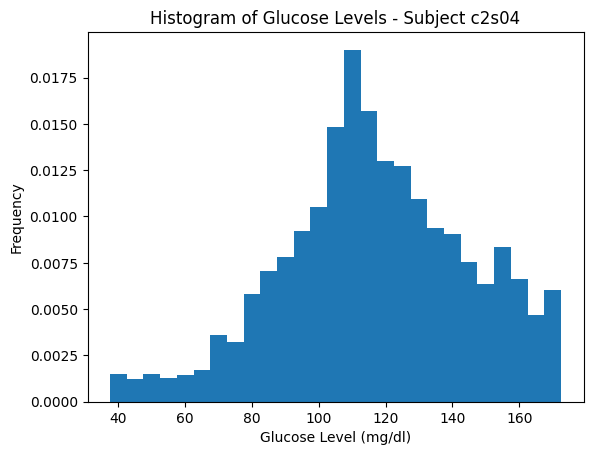

In [87]:
# generate the histogram of glucose levels
bins = np.arange(40, 180, 5)
hist, _ = np.histogram(clean_df['glucose'], bins=bins, density=True)

plt.bar(bins[:-1], hist, width=5)
plt.xlabel('Glucose Level (mg/dl)')
plt.ylabel('Frequency')
plt.title('Histogram of Glucose Levels - Subject {}'.format(subject_id))
plt.show()
